In [127]:
import numpy as np
import torch
import gc
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as torchvision_models
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from torchmetrics.image import StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchsummary import summary
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from PIL import Image
import random
import cv2
import os

In [128]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [129]:
# Define transformations for grayscale and color images
transform_gray = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.ToTensor()  # Convert images to tensors
])
transform_color = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to tensors
])
def list_files_in_directory(directory):
    files = os.listdir(directory)
    return files
train_files = list_files_in_directory("train")
test_files = list_files_in_directory("test")
validation_files = list_files_in_directory("validation")

In [130]:
def process_dataset(original_data):
    gray_data = []
    color_data = []

    for image in original_data:
        # Apply transformations
        image_resized_color = transform_color(image)
        image_resized_gray = transform_gray(image)
        
        # Convert color image tensor to HSV
        image_np = TF.to_pil_image(image_resized_color)  # Convert tensor to PIL image
        image_np = np.array(image_np)  # Convert PIL image to numpy array
        hsv_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)
        
        # Split HSV channels and normalize
        h, s, v = cv2.split(hsv_image)
        h_tensor = torch.tensor(h / 179.0, dtype=torch.float32)
        s_tensor = torch.tensor(s / 255.0, dtype=torch.float32)
        v_tensor = torch.tensor(v / 255.0, dtype=torch.float32)
        
        # Stack the channels
        hsv_tensor = torch.stack((h_tensor, s_tensor, v_tensor), dim=0)
                
        # Append the grayscale and HSV images to their respective lists
        gray_data.append(image_resized_gray)
        color_data.append(hsv_tensor)

    return gray_data, color_data


In [131]:
def read_images_from_directory(directory):
    images = []
    files = os.listdir(directory)
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
            file_path = os.path.join(directory, file)
            image = Image.open(file_path)
            images.append(image)
    return images

# Example usage
train_data = read_images_from_directory("train")
test_data = read_images_from_directory("test")
validation_data = read_images_from_directory("validation")

In [132]:
gray_data_train,      color_data_train      = process_dataset(train_data)
gray_data_test,       color_data_test       = process_dataset(test_data)
gray_data_validation, color_data_validation = process_dataset(validation_data)

In [133]:
print("Size of grayscale dataset:", len(gray_data_train))
print("Size of color dataset:", len(color_data_train))
gray_image_shape  = gray_data_train[0][0].shape
print("Shape of the first grayscale image tensor:", gray_image_shape)
color_image_shape = color_data_train[0][0].shape
print("Shape of the first color image tensor:", color_image_shape)
gray_image_shape  = gray_data_train[0].shape
print("Shape of the first grayscale image tensor:", gray_image_shape)
color_image_shape = color_data_train[0].shape
print("Shape of the first color image tensor:", color_image_shape)

Size of grayscale dataset: 69
Size of color dataset: 69
Shape of the first grayscale image tensor: torch.Size([128, 128])
Shape of the first color image tensor: torch.Size([128, 128])
Shape of the first grayscale image tensor: torch.Size([1, 128, 128])
Shape of the first color image tensor: torch.Size([3, 128, 128])


In [134]:
def plot_hsv_histograms(color_data, num_samples=3):
    for i in range(num_samples):
        index = random.randint(0, len(color_data) - num_samples)
        hsv_image = color_data[i+index]
        h, s, v = hsv_image

        # Plot histograms
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].hist(h.flatten(), bins=256, color='r')
        axes[0].set_title('Hue Histogram')
        axes[1].hist(s.flatten(), bins=256, color='g')
        axes[1].set_title('Saturation Histogram')
        axes[2].hist(v.flatten(), bins=256, color='b')
        axes[2].set_title('Value Histogram')
        plt.show()

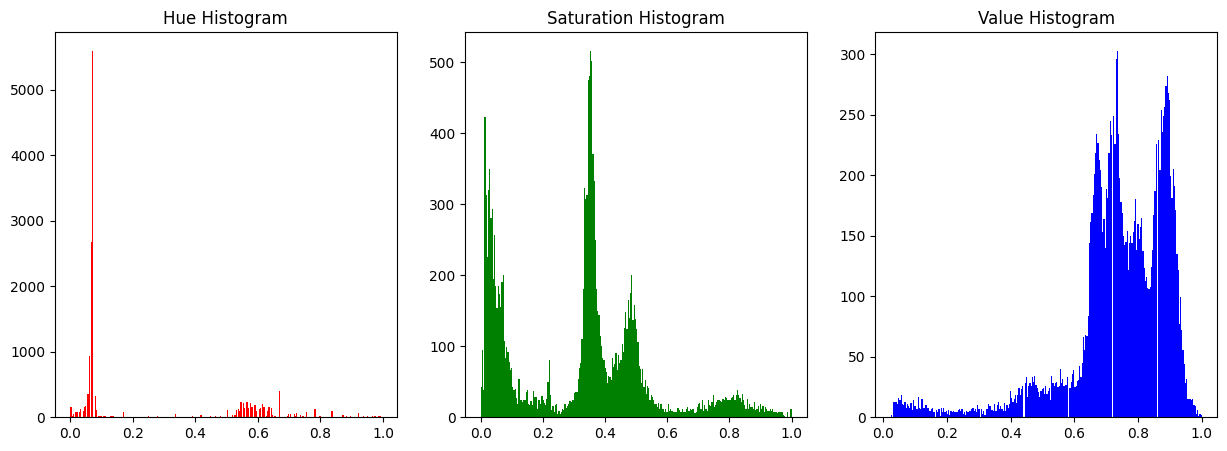

In [135]:
plot_hsv_histograms(color_data_train, num_samples=1)

In [136]:
def visualize_random_images(gray_data, color_data):
    index = random.randint(0, len(gray_data) - 1)
    gray_image = gray_data[index]
    color_image = color_data[index]

    plt.subplot(1, 2, 1)
    plt.imshow(gray_image.squeeze(0), cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(hsv_to_rgb(color_image.permute(1, 2, 0)))
    plt.title('Color Image')
    plt.axis('off')
    plt.show()


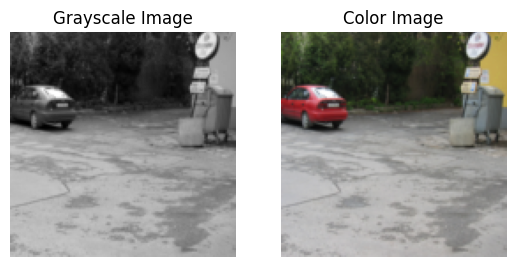

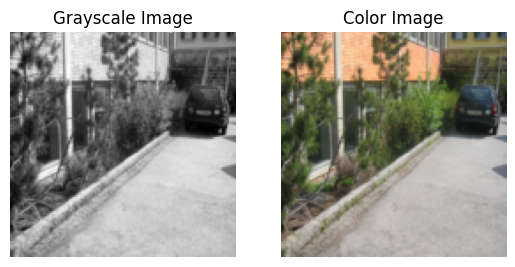

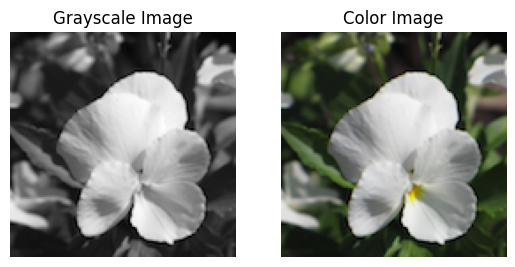

In [137]:
visualize_random_images(gray_data_train,      color_data_train)
visualize_random_images(gray_data_test,       color_data_test)
visualize_random_images(gray_data_validation, color_data_validation)

In [138]:
gray_images_train  = torch.stack(gray_data_train)
color_images_train = torch.stack(color_data_train)
gray_images_test   = torch.stack(gray_data_test)
color_images_test  = torch.stack(color_data_test)
gray_images_val    = torch.stack(gray_data_validation)
color_images_val   = torch.stack(color_data_validation)

In [139]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        
        # Decoder
        x = self.decoder(x)
        
        return x

In [140]:
class Model_a(nn.Module):
    def __init__(self):
        super(Model_a, self).__init__()
        # Shared layer
        self.shared_layer = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Output layers
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Shared layer
        x = self.shared_layer(x)
        # Split into three branches
        output1 = self.decoder1(x)
        output2 = self.decoder2(x)
        output3 = self.decoder3(x)
        
        # Concatenate outputs along the channel dimension
        combined_output = torch.cat((output1, output2, output3), dim=1)
        
        return combined_output

In [141]:
class Model_b(nn.Module):
    def __init__(self):
        super(Model_b, self).__init__()
        # Initial layer to match input channels
        self.initial_layer = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # Assuming input channels are 128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Shared layer
        self.shared_layer = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsampling
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Further upsampling
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Output layers - each layer outputs at 128x128 resolution
        self.decoder1 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
        self.decoder2 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
        self.decoder3 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial_layer(x)
        x = self.shared_layer(x)
        # Ensure output dimensions are [batch_size, 1, 128, 128]
        output1 = F.interpolate(self.decoder1(x), size=(128, 128), mode='bilinear', align_corners=False)
        output2 = F.interpolate(self.decoder2(x), size=(128, 128), mode='bilinear', align_corners=False)
        output3 = F.interpolate(self.decoder3(x), size=(128, 128), mode='bilinear', align_corners=False)
        
        # Combine the outputs along the channel dimension to form [batch_size, 3, 128, 128]
        combined_output = torch.cat((output1, output2, output3), dim=1)
        
        return combined_output

In [142]:
class Model_c(nn.Module):
    def __init__(self):
        super(Model_c, self).__init__()
        # Initial layer to match input channels
        self.initial_layer = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Shared layer
        self.shared_layer = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upscaling
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Output layers, resizing to [128, 128]
        self.decoder1 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
        self.decoder2 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
        self.decoder3 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial_layer(x)
        x = self.shared_layer(x)
        # Ensure each output is resized to 128x128
        output1 = F.interpolate(self.decoder1(x), size=(128, 128), mode='bilinear', align_corners=False)
        output2 = F.interpolate(self.decoder2(x), size=(128, 128), mode='bilinear', align_corners=False)
        output3 = F.interpolate(self.decoder3(x), size=(128, 128), mode='bilinear', align_corners=False)
        
        # Combine the outputs along the channel dimension to form [batch_size, 3, 128, 128]
        combined_output = torch.cat((output1, output2, output3), dim=1)
        
        return combined_output

In [143]:
class Model_d(nn.Module):
    def __init__(self):
        super(Model_d, self).__init__()
        # Initial layer to match input channels
        self.initial_layer = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Shared layer
        self.shared_layer = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Refinement layers
        self.refinement_layers = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Output layer
        self.output_layer = nn.Sequential(
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial_layer(x)
        x = self.shared_layer(x)
        x = self.refinement_layers(x)
        output = self.output_layer(x)
        return output

In [144]:
def create_ColorCombinationModel():
    return ColorizationModel()
def create_colorization_model_a():
    return Model_a()
def create_colorization_model_b():
    return Model_b()
def create_colorization_model_c():
    return Model_c()
def create_colorization_model_d():
    return Model_d()

In [145]:
Model_A = create_colorization_model_a()
Model_A.load_state_dict(torch.load("Model_A.pth"))
Model_B = create_colorization_model_b()
Model_B.load_state_dict(torch.load("Model_B.pth"))
Model_C = create_colorization_model_c()
Model_C.load_state_dict(torch.load("Model_C.pth"))
Model_D = create_colorization_model_d()
Model_D.load_state_dict(torch.load("Model_D.pth"))

<All keys matched successfully>

In [146]:
def invert_images(images):
    # Assuming images are normalized to [0, 1]
    return 1 - images


In [147]:
def normalize_tensor(tensor):
    min_val, _ = tensor.min(dim=1, keepdim=True)
    min_val, _ = min_val.min(dim=2, keepdim=True)
    min_val, _ = min_val.min(dim=3, keepdim=True)
    
    max_val, _ = tensor.max(dim=1, keepdim=True)
    max_val, _ = max_val.max(dim=2, keepdim=True)
    max_val, _ = max_val.max(dim=3, keepdim=True)
    
    normalized_tensor = (tensor - min_val) / (max_val - min_val)
    return normalized_tensor

In [148]:
def build_data_loader(gray_images_train, color_images_train, batch_size):
    # Assuming necessary model creation functions and invert_images are defined

    # Load and prepare models
    Auto_encoder = create_ColorCombinationModel()
    encoder = Auto_encoder.encoder
    model_encoder_trained = 'model_encoder_trained.pth'
    encoder.load_state_dict(torch.load(model_encoder_trained))

    Model_A = create_colorization_model_a()
    Model_A.load_state_dict(torch.load("Model_A.pth"))
    Model_B = create_colorization_model_b()
    Model_B.load_state_dict(torch.load("Model_B.pth"))
    Model_C = create_colorization_model_c()
    Model_C.load_state_dict(torch.load("Model_C.pth"))
    Model_D = create_colorization_model_d()
    Model_D.load_state_dict(torch.load("Model_D.pth"))

    # Encode grayscale images
    gray_data_train_from_encoder = encoder(gray_images_train)

    # Get outputs from each model
    train_Output_from_model_A = Model_A(gray_data_train_from_encoder)
    train_Output_from_model_B = Model_B(gray_data_train_from_encoder)
    train_Output_from_model_C = Model_C(gray_data_train_from_encoder)
    train_Output_from_model_D = Model_D(gray_data_train_from_encoder)

    # Invert outputs
    #train_Output_from_model_A_invert = invert_images(train_Output_from_model_A)[:, 1, :, :].unsqueeze(1)
    #train_Output_from_model_B_invert = invert_images(train_Output_from_model_B)[:, 1, :, :].unsqueeze(1)
    #train_Output_from_model_C_invert = invert_images(train_Output_from_model_C)[:, 1, :, :].unsqueeze(1)
    #train_Output_from_model_D_invert = invert_images(train_Output_from_model_D)[:, 1, :, :].unsqueeze(1)

    # Extract the first output channel and combine them
    first_output_A = train_Output_from_model_A[:, 0, :, :].unsqueeze(1)
    first_output_B = train_Output_from_model_B[:, 0, :, :].unsqueeze(1)
    first_output_C = train_Output_from_model_C[:, 0, :, :].unsqueeze(1)
    first_output_D = train_Output_from_model_D[:, 0, :, :].unsqueeze(1)

    combined_input = torch.cat([first_output_A, first_output_B, first_output_C, first_output_D], dim=1)
    #combined_input_invert = torch.cat([train_Output_from_model_A_invert, train_Output_from_model_B_invert, train_Output_from_model_C_invert, train_Output_from_model_D_invert], dim=1)

    # Combine both original and inverted inputs into a single tensor along a new dimension
    #all_inputs = torch.cat([combined_input, combined_input_invert], dim=0)

    # Prepare the color images
    color_images_train_first_channel = color_images_train[:, 0, :, :].unsqueeze(1)
    #color_images_train_first_channel_invert = invert_images(color_images_train)[:, 0, :, :].unsqueeze(1)

    # Combine both original and inverted color images into a single tensor along the same new dimension
    #all_color_images = torch.cat([color_images_train_first_channel, color_images_train_first_channel_invert], dim=0)

    # Create TensorDataset with combined inputs and color images
    #dataset_train = TensorDataset(all_inputs, all_color_images)
    dataset_train = TensorDataset(combined_input, color_images_train_first_channel)
    # Create DataLoader
    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, pin_memory=True)

    return train_loader

In [149]:
batch_size = 10
train_loader = build_data_loader(gray_images_train, color_images_train, batch_size)
val_loader   = build_data_loader(gray_images_val  , color_images_val  , len(gray_data_validation))

In [150]:
for batch_idx, (inputs_gray, targets_color) in enumerate(train_loader):
    print("Batch Index:", batch_idx)
    print("Shape of inputs (grayscale images):", inputs_gray.shape)
    print("Shape of targets (color images):"   , targets_color.shape)
    break  # Print only the first batch

Batch Index: 0
Shape of inputs (grayscale images): torch.Size([10, 4, 128, 128])
Shape of targets (color images): torch.Size([10, 1, 128, 128])


In [151]:
for batch_idx, (inputs_gray, targets_color) in enumerate(val_loader):
    print("Batch Index:", batch_idx)
    print("Shape of inputs (grayscale images):", inputs_gray.shape)
    print("Shape of targets (color images):"   , targets_color.shape)
num_batches = len(val_loader)
batch_size = val_loader.batch_size
print("Number of batches in val_loader:   " , num_batches)
print("Size of each batch in val_loader:  ", batch_size)

Batch Index: 0
Shape of inputs (grayscale images): torch.Size([70, 4, 128, 128])
Shape of targets (color images): torch.Size([70, 1, 128, 128])
Number of batches in val_loader:    1
Size of each batch in val_loader:   70


In [152]:
def visualize_images_from_dataloader(dataloader, n_images=5):
    data_iter = iter(dataloader)
    fig, axs = plt.subplots(n_images, 5, figsize=(15, n_images * 3))  # 5 columns: 4 for input channels, 1 for target
    
    if n_images == 1:
        axs = axs.reshape(-1, 5)  # Reshape axs to maintain consistent indexing

    for i in range(n_images):
        try:
            inputs, targets = next(data_iter)
        except StopIteration:
            break  # Break if there are fewer images than n_images

        for channel in range(inputs.shape[1]):
            image = inputs[0, channel].cpu().detach().numpy()  # Get the channel image
            axs[i, channel].imshow(image, cmap='gray')
            axs[i, channel].set_title(f'Input Channel {channel+1}')
            axs[i, channel].axis('off')

        # Display the target image
        target_image = targets[0, 0].cpu().detach().numpy()  # There's only one channel in targets
        axs[i, 4].imshow(target_image, cmap='gray')
        axs[i, 4].set_title('Target Image')
        axs[i, 4].axis('off')

    plt.tight_layout()
    plt.show()

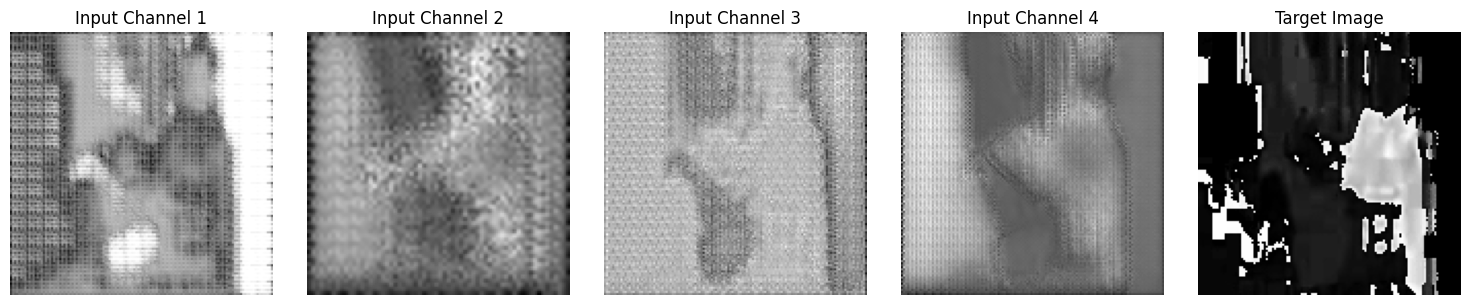

In [153]:
visualize_images_from_dataloader(train_loader, n_images=1)

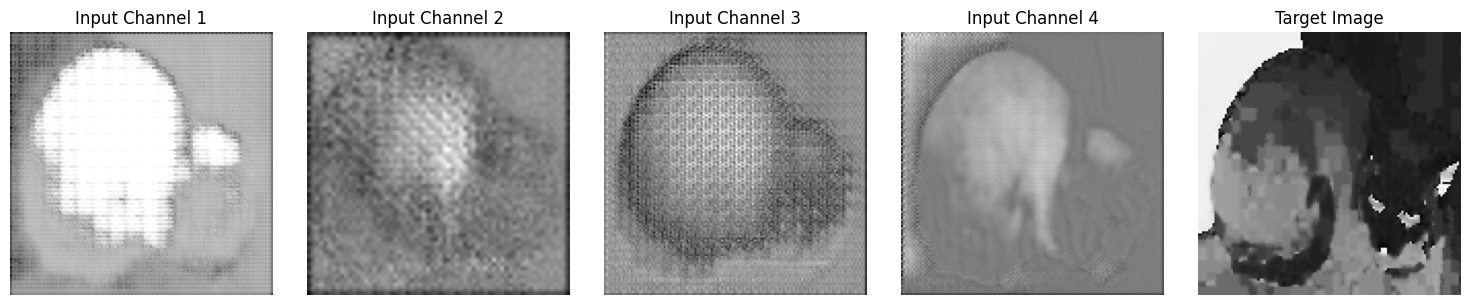

In [154]:
visualize_images_from_dataloader(val_loader, n_images=1)

In [155]:
class SingleChannelModel(nn.Module):
    def __init__(self):
        super(SingleChannelModel, self).__init__()

        # Initial layers
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU6(inplace=True)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # [batch, 32, 64, 64]
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # [batch, 64, 32, 32]

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # [batch, 64, 64, 64]
        self.bn5 = nn.BatchNorm2d(64)
        
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # [batch, 32, 128, 128]
        self.bn6 = nn.BatchNorm2d(32)

        self.conv5 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        
    def forward(self, x):
        x1 = self.relu(self.bn1(self.conv1(x)))  # [batch, 16, 128, 128]
        x2 = self.relu(self.bn2(self.conv2(x1)))  # [batch, 32, 128, 128]
        x2p = self.pool1(x2)  # [batch, 32, 64, 64]

        x3 = self.relu(self.bn3(self.conv3(x2p)))  # [batch, 64, 64, 64]
        x3p = self.pool2(x3)  # [batch, 64, 32, 32]

        x4 = self.relu(self.bn4(self.conv4(x3p)))  # [batch, 128, 32, 32]

        x = self.relu(self.bn5(self.upconv1(x4)))  # [batch, 64, 64, 64]
        x3p_upsampled = F.interpolate(x3p, size=x.shape[2:], mode='nearest')
        x = x + x3p_upsampled

        x = self.relu(self.bn6(self.upconv2(x)))  # [batch, 32, 128, 128]
        x2p_upsampled = F.interpolate(x2p, size=x.shape[2:], mode='nearest')
        x = x + x2p_upsampled
        
        x = self.conv5(x)  # [batch, 1, 128, 128]
        return x


In [156]:
def ChannelAttention_H():
    return SingleChannelModel()

In [157]:
def visualize_model_output(model, val_loader_from_decoder):
    # Select a random image from the validation loader
    inputs_gray, targets_gray = next(iter(val_loader_from_decoder))
    idx = random.randint(0, len(inputs_gray) - 1)
    input_gray_sample = inputs_gray[idx]
    target_gray_sample = targets_gray[idx]
    
    # Generate model output
    model.eval()
    with torch.no_grad():
        output = model(input_gray_sample.unsqueeze(0).to(next(model.parameters()).device)).cpu()
    output_clipped = torch.clamp(output, 0, 1)
    
    # Create a new figure
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))  # Four panels: two images, two histograms
    
    # Plot the input grayscale image
    axes[0].imshow(target_gray_sample.squeeze().detach().numpy(), cmap='gray')
    axes[0].set_title("Input Grayscale Image")
    axes[0].axis('off')

    # Plot the histogram for the input grayscale image
    axes[1].hist(target_gray_sample.detach().numpy().flatten(), bins=256, range=(0, 1), alpha=0.75, color='gray')
    axes[1].set_title('Histogram of Input Grayscale Image')
    
    # Plot the model output image
    axes[2].imshow(output_clipped.squeeze().detach().numpy(), cmap='gray')
    axes[2].set_title("Model Output Image")
    axes[2].axis('off')
    
    # Plot histogram for the model output image
    axes[3].hist(output_clipped.squeeze().detach().numpy().flatten(), bins=256, range=(0, 1), alpha=0.75, color='gray')
    axes[3].set_title('Histogram of Model Output Image')

    plt.tight_layout()
    plt.show()

In [158]:
Model_Hue = ChannelAttention_H()
Model_Hue.cuda()  # Move the model to GPU
# Assuming you have a DataLoader named 'val_loader'
x, y = next(iter(val_loader))
print(f'Input shape: {x.shape}')

y_hat = Model_Hue(x.cuda())  # Ensure the model and data are on the same device
print(f'Output shape: {y_hat.shape}')
print(f'True output shape: {y.shape}')
Model_Hue.cuda()
x, y = next(iter(val_loader))
yHat = Model_Hue((x.cuda()))
summary(Model_Hue, (4, 128, 128))

Input shape: torch.Size([70, 4, 128, 128])
Output shape: torch.Size([70, 1, 128, 128])
True output shape: torch.Size([70, 1, 128, 128])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             592
       BatchNorm2d-2         [-1, 16, 128, 128]              32
             ReLU6-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
         MaxPool2d-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          18,496
       BatchNorm2d-9           [-1, 64, 64, 64]             128
            ReLU6-10           [-1, 64, 64, 64]               0
        MaxPool2d-11           [-1, 64, 32, 32]               0
           Conv2d-12          [

In [159]:
class PerceptualLoss(nn.Module):
    def __init__(self, feature_layers=[0, 5, 10, 19, 28], use_normalization=True):
        super(PerceptualLoss, self).__init__()
        self.vgg = torchvision_models.vgg19(weights=torchvision_models.VGG19_Weights.IMAGENET1K_V1).features[:max(feature_layers)+1].eval()
        self.feature_layers = feature_layers
        self.use_normalization = use_normalization
        if use_normalization:
            self.mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to('cuda')
            self.std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to('cuda')
    
    def forward(self, x, y):
        if self.use_normalization:
            x = (x - self.mean) / self.std
            y = (y - self.mean) / self.std
        x_features = self.get_features(x)
        y_features = self.get_features(y)
        loss = sum([nn.MSELoss()(x_f, y_f) for x_f, y_f in zip(x_features, y_features)])
        return loss
    
    def get_features(self, x):
        features = []
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in self.feature_layers:
                features.append(x)
        return features

In [160]:
def train_model(model, train_loader, val_loader, optimizer_configs, criterion_list, epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)  # Transfer the model to the GPU if available
    
    train_losses = []
    val_losses = []
    
    # Pair each criterion with its corresponding optimizer
    pairs = []
    for crit in criterion_list:
        for optim in optimizer_configs[crit]:
            pairs.append((crit, optim))
    #random.shuffle(pairs) # Shuffle the list to ensure random order of training with different pairs

    current_criterion, current_optimizer = pairs[2]
    
    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0

        # Change the loss function every epochs
        if (epoch - 1) % 10 == 0 and epoch != 1:
            current_criterion, current_optimizer = pairs[(pairs.index((current_criterion, current_optimizer)) + 1) % len(pairs)]
            print(f"Switching to {current_criterion.__class__.__name__} as the loss function.")

        # Training loop
        for images, labels in train_loader:
            images = images.to(device)  # Transfer images to the GPU if available
            labels = labels.to(device)  # Transfer labels to the GPU if available
            current_optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = current_criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward(retain_graph=True)
            current_optimizer.step()

            running_loss += loss.item() * images.size(0)

        # Calculate average training loss
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)  # Transfer images to the GPU if available
                labels = labels.to(device)  # Transfer labels to the GPU if available
                outputs = model(images)
                val_loss += current_criterion(outputs, labels).item() * images.size(0)

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f"Epoch {epoch}/{epochs}, Loss: {type(current_criterion).__name__}, Optimizer: {type(current_optimizer).__name__}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Print epoch statistics
        if epoch % 3 == 0:
            model.to('cpu')  # Move the model to CPU if it's not already there
            visualize_model_output(model, train_loader) 
            model.to(device)
    return train_losses, val_losses, model


In [161]:
class SSIMLoss(nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = self.create_window(window_size, self.channel)

    def create_window(self, window_size, channel):
        # Ensure all operations are on tensors
        _1D_window = torch.Tensor([0.5 * (1.0 + torch.cos(2 * torch.tensor(3.141592653589793) * torch.tensor(x / (window_size - 1) - 0.5))) for x in range(window_size)])
        _1D_window = _1D_window / _1D_window.sum()
        _2D_window = _1D_window.unsqueeze(1).mm(_1D_window.unsqueeze(0)).float().unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
        return window

    def ssim(self, img1, img2):
        (_, channel, _, _) = img1.size()
        window = self.window.type_as(img1)

        mu1 = F.conv2d(img1, window, padding=self.window_size // 2, groups=channel)
        mu2 = F.conv2d(img2, window, padding=self.window_size // 2, groups=channel)

        mu1_sq = mu1 ** 2
        mu2_sq = mu2 ** 2
        mu1_mu2 = mu1 * mu2

        sigma1_sq = F.conv2d(img1 * img1, window, padding=self.window_size // 2, groups=channel) - mu1_sq
        sigma2_sq = F.conv2d(img2 * img2, window, padding=self.window_size // 2, groups=channel) - mu2_sq
        sigma12 = F.conv2d(img1 * img2, window, padding=self.window_size // 2, groups=channel) - mu1_mu2

        C1 = 0.01 ** 2
        C2 = 0.03 ** 2

        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

        if self.size_average:
            return ssim_map.mean()
        else:
            return ssim_map.mean(1).mean(1).mean(1)

    def forward(self, img1, img2):
        return 1 - self.ssim(img1, img2)

Epoch 1/20, Loss: function, Optimizer: Adam, Train Loss: 0.9883, Val Loss: 0.9121
Epoch 2/20, Loss: function, Optimizer: Adam, Train Loss: 0.9752, Val Loss: 0.9062
Epoch 3/20, Loss: function, Optimizer: Adam, Train Loss: 0.9662, Val Loss: 0.8930


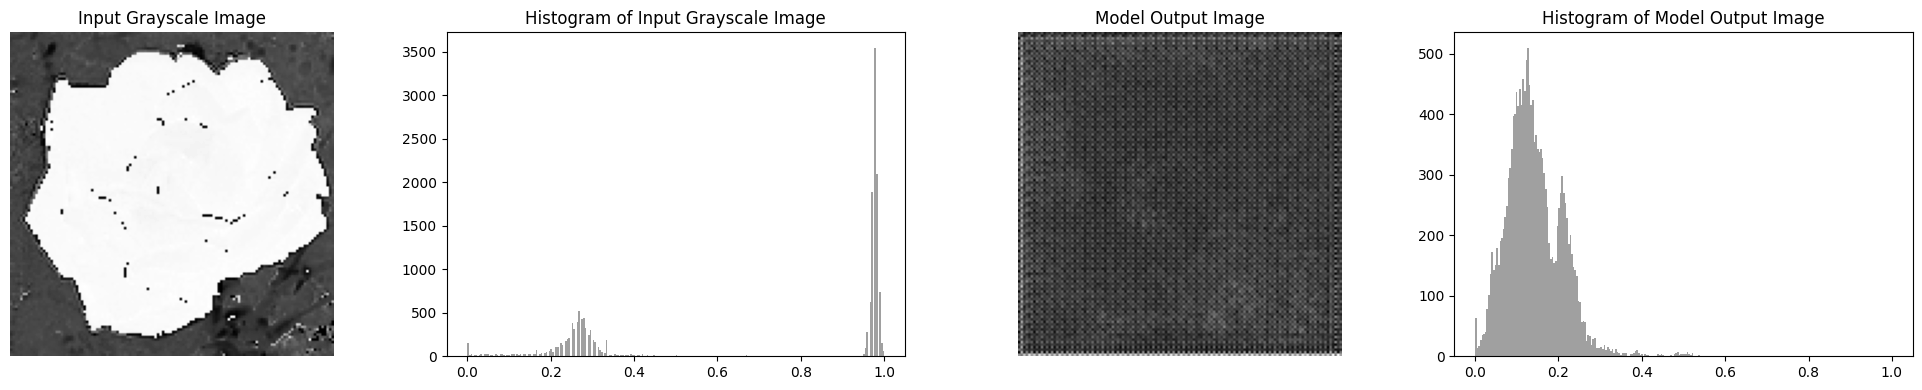

Epoch 4/20, Loss: function, Optimizer: Adam, Train Loss: 0.9567, Val Loss: 0.8869
Epoch 5/20, Loss: function, Optimizer: Adam, Train Loss: 0.9481, Val Loss: 0.8761
Epoch 6/20, Loss: function, Optimizer: Adam, Train Loss: 0.9375, Val Loss: 0.8847


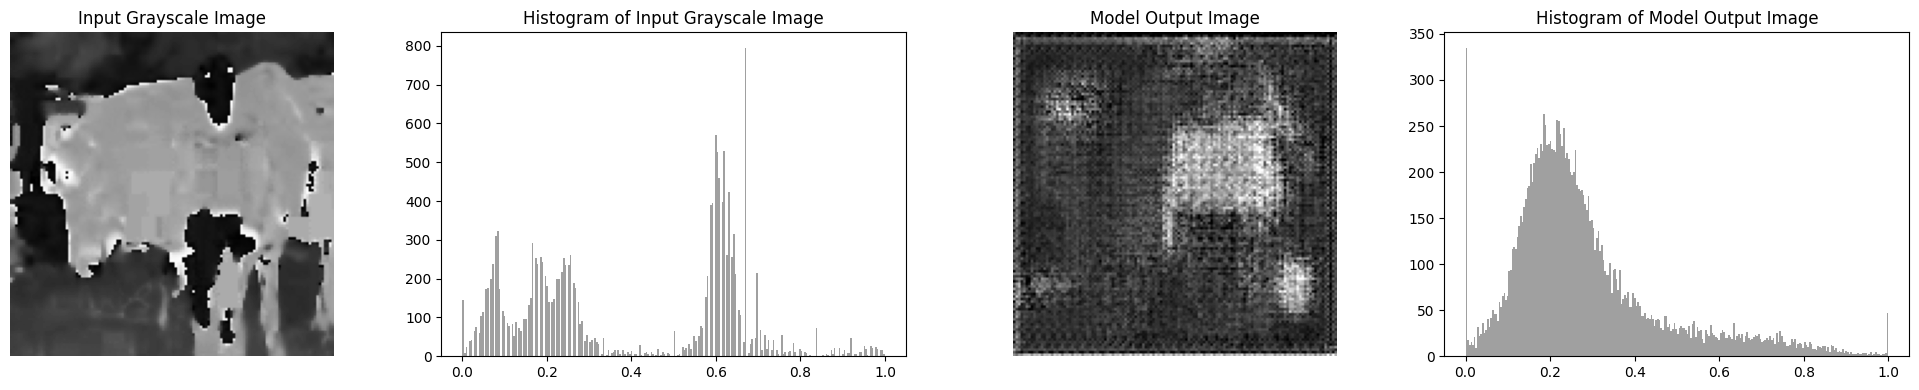

Epoch 7/20, Loss: function, Optimizer: Adam, Train Loss: 0.9331, Val Loss: 0.8970
Epoch 8/20, Loss: function, Optimizer: Adam, Train Loss: 0.9230, Val Loss: 0.9067
Epoch 9/20, Loss: function, Optimizer: Adam, Train Loss: 0.9139, Val Loss: 0.9136


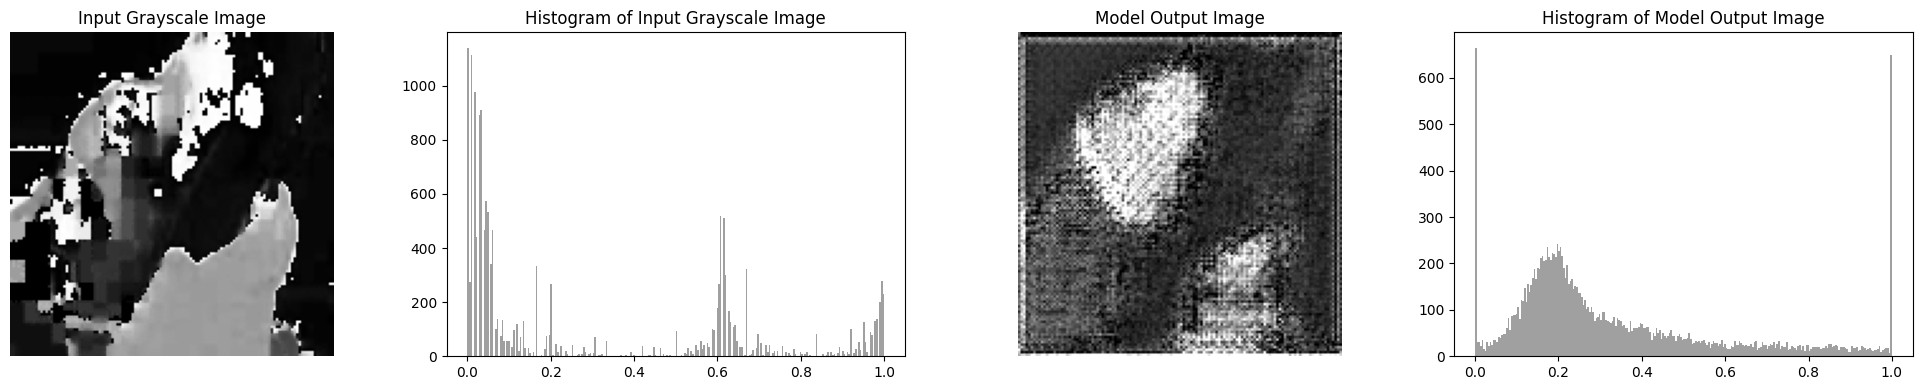

Epoch 10/20, Loss: function, Optimizer: Adam, Train Loss: 0.9050, Val Loss: 0.9149
Switching to function as the loss function.
Epoch 11/20, Loss: function, Optimizer: RMSprop, Train Loss: 0.9406, Val Loss: 0.9434
Epoch 12/20, Loss: function, Optimizer: RMSprop, Train Loss: 0.9068, Val Loss: 0.9263


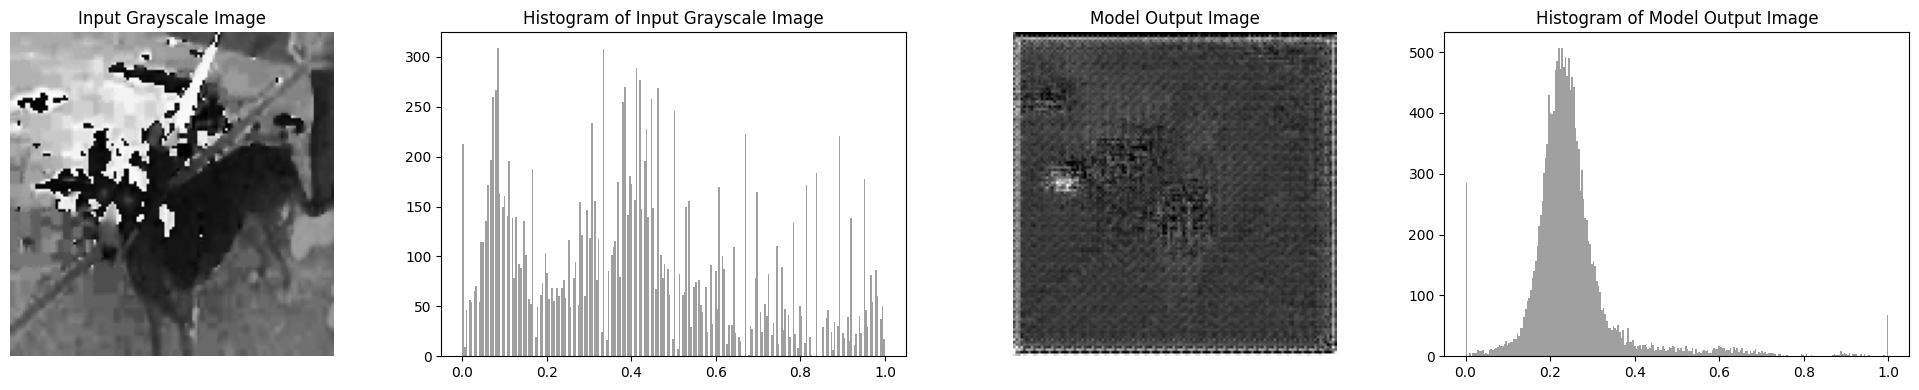

Epoch 13/20, Loss: function, Optimizer: RMSprop, Train Loss: 0.8723, Val Loss: 0.9102
Epoch 14/20, Loss: function, Optimizer: RMSprop, Train Loss: 0.8479, Val Loss: 0.8923
Epoch 15/20, Loss: function, Optimizer: RMSprop, Train Loss: 0.8351, Val Loss: 0.8744


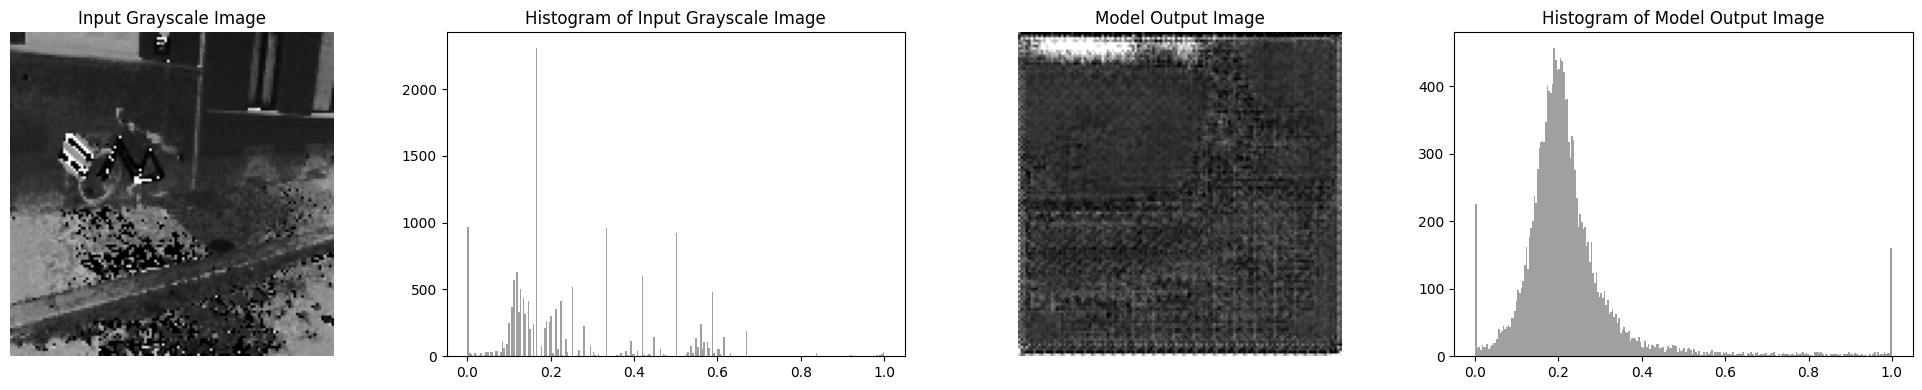

Epoch 16/20, Loss: function, Optimizer: RMSprop, Train Loss: 0.8153, Val Loss: 0.8612
Epoch 17/20, Loss: function, Optimizer: RMSprop, Train Loss: 0.8097, Val Loss: 0.8491
Epoch 18/20, Loss: function, Optimizer: RMSprop, Train Loss: 0.7987, Val Loss: 0.8363


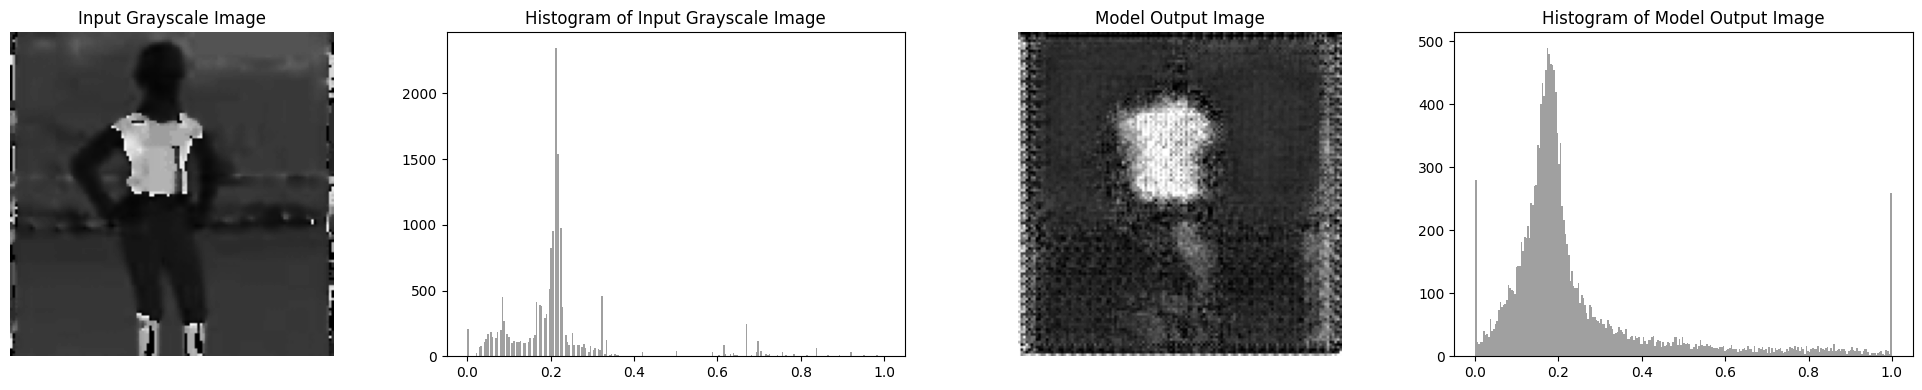

Epoch 19/20, Loss: function, Optimizer: RMSprop, Train Loss: 0.7923, Val Loss: 0.8248
Epoch 20/20, Loss: function, Optimizer: RMSprop, Train Loss: 0.7879, Val Loss: 0.8130


In [162]:
mse_loss = nn.MSELoss().to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
ssim_loss = lambda output, target: 1 - ssim_metric(output, target.to(device))

lr_divisor = 1
optimizer_configs = {
    mse_loss:  [optim.Adam(   Model_Hue.parameters(), lr=0.00005 / lr_divisor),
                optim.RMSprop(Model_Hue.parameters(), lr=0.00001 / lr_divisor)],
    ssim_loss: [optim.Adam(   Model_Hue.parameters(), lr=0.0001  / lr_divisor),
                optim.RMSprop(Model_Hue.parameters(), lr=0.0001  / lr_divisor)]
}

criterion_list = [mse_loss, ssim_loss]

epochs = 20
# Train the model
train_losses, val_losses, Model_Hue = train_model(Model_Hue, train_loader, val_loader, optimizer_configs, criterion_list, epochs)

In [163]:
def plot_losses(train_losses_list, val_losses_list):
    plt.figure(figsize=(10, 6))

    # Plot training losses
    if isinstance(train_losses_list[0], list):
        for i, train_losses in enumerate(train_losses_list):
            plt.plot(range(1, len(train_losses) + 1), train_losses, label=f"Model {i+1} - Train Loss")
    else:
        plt.plot(range(1, len(train_losses_list) + 1), train_losses_list, label="Train Loss")

    # Plot validation losses
    if isinstance(val_losses_list[0], list):
        for i, val_losses in enumerate(val_losses_list):
            plt.plot(range(1, len(val_losses) + 1), val_losses, label=f"Model {i+1} - Validation Loss", linestyle='--')
    else:
        plt.plot(range(1, len(val_losses_list) + 1), val_losses_list, label="Validation Loss", linestyle='--')

    plt.title("Train and Validation Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

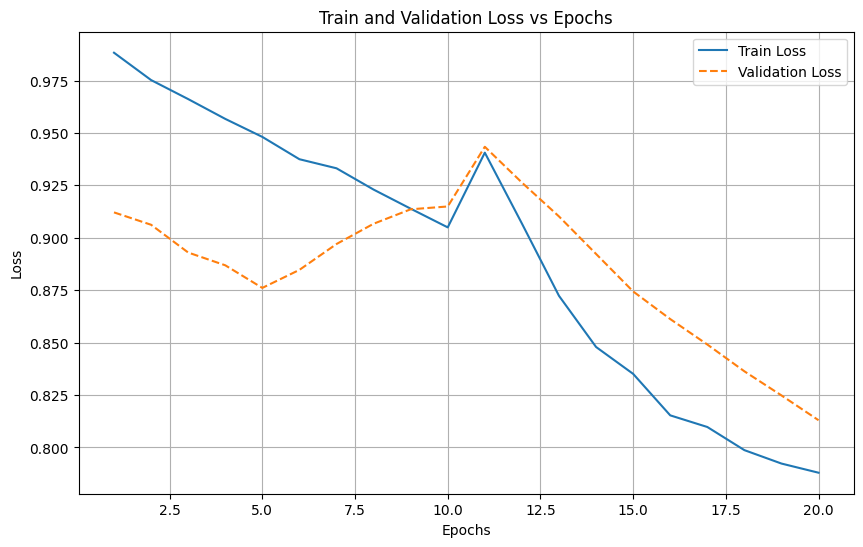

In [164]:
plot_losses(train_losses, val_losses)

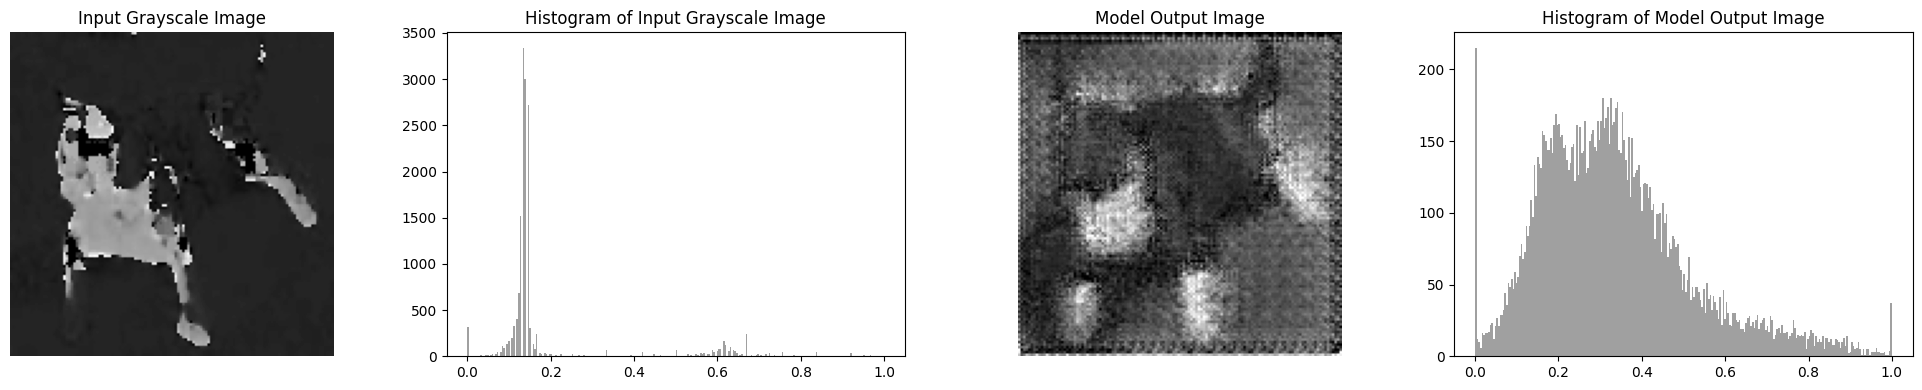

In [173]:
Model_Hue.to('cpu')  # Ensure the model is on the CPU if you're not using CUDA
visualize_model_output(Model_Hue, val_loader)

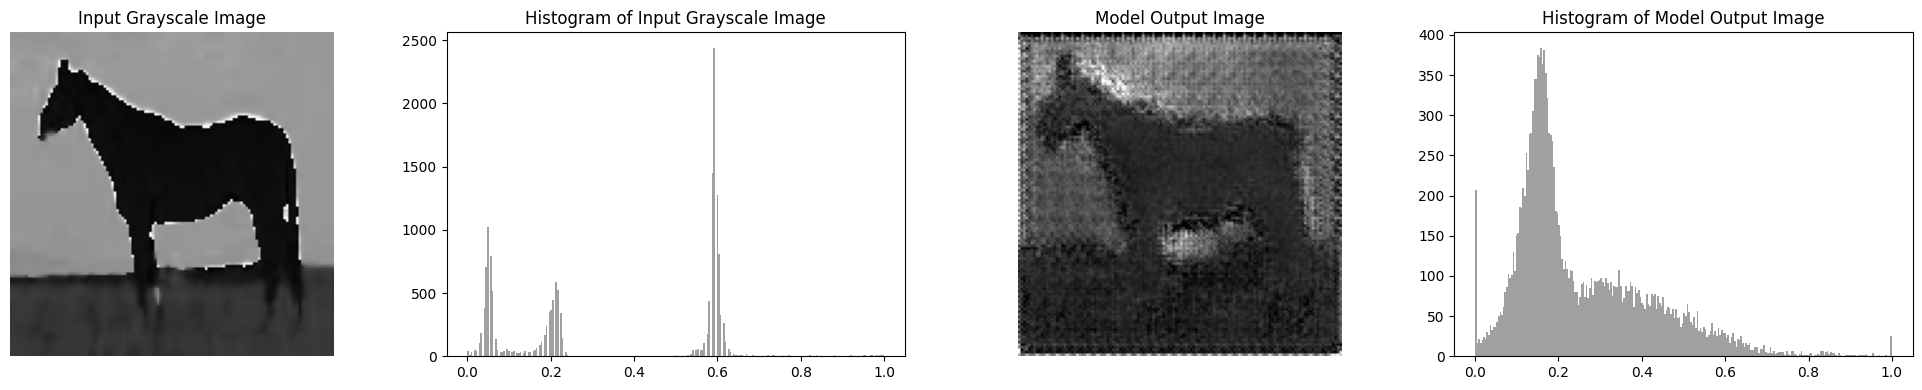

In [171]:
Model_Hue.to('cpu')  # Move the model to CPU if it's not already there
visualize_model_output(Model_Hue, train_loader) 

In [167]:
torch.save(Model_Hue.state_dict(), "Model_Hue.pth")